In [13]:
import pandas as pd
import numpy as np
# from data_preprocess import data_cleaning, scaling, data_spliting  ### Dont forget to restart the Kernel and re-import if any changes has been made to the methods ###
from performance_eval import error_stats
from data_preprocess import DataPreprocess as dp

# ********** Import when RSSI fingerprints and weather data are used to train *********** #
####### ************************ If you don't want to go through loading and preprocessing steps again, skip the 1st 6 cells and directly load the preprocessed data from the 
# saved files executing from the 7th cell *************************** ############################
ds = pd.read_csv("data/antwerp_combo_raw_ref.csv")

# ********** Import when RSSI+TDoA fingerprinting and weather data are used to train ************ #
# ds = pd.read_csv("data/antwerp_19_rssi_weather_tdoa.csv", index_col=0)

In [14]:
### **************** Execute cell for RSSI fingerprinting *********************** ###
x_rssi, y = dp().data_cleaning(ds, wathear_data=False)
# x_weather, y = dp().data_cleaning(ds, wathear_data=True)

# pd.DataFrame(x_weather).to_csv('files/x_weather.csv')
# pd.DataFrame(y).to_csv('files/y_weather.csv')

Size before cleaning:  (130282, 114)
Size after cleaning:  (55303, 114)


In [3]:
### **************** Execute cell for RSSI+TDoA fingerprinting *********************** ###

# x_weather = ds.drop(columns=['Latitude', 'Longitude'], axis=1)
# y = ds[['Latitude', 'Longitude']]

In [15]:
x_rssi_scaled = dp().scaling(scaler='MinMax', x=x_rssi.drop(columns=['RX Time', 'gw_info_row_id'], axis=1))  # remove the timestamp. will be added later 
# x_w_scaled = dp().scaling(scaler='MinMax', x=x_weather.drop(columns=['RX Time', 'gw_info_row_id'], axis=1))  # remove the timestamp. will be added later 

x_rssi_scaled['timestamp'] = x_rssi['RX Time']
x_rssi_scaled['gw_ref'] = x_rssi['gw_info_row_id']
# x_w_scaled['timestamp'] = x_weather['RX Time']
# x_w_scaled['gw_ref'] = x_weather['gw_info_row_id']

x_rssi_train, x_rssi_test, x_rssi_val, y_rssi_train, y_rssi_test, y_rssi_val = dp().data_spliting(x_scaled=x_rssi_scaled, y=y, train_size=0.7, random_state=42, val_size=0.001)
# x_w_train, x_w_test, x_w_val, y_w_train, y_w_test, y_w_val = dp().data_spliting(x_scaled=x_w_scaled, y=y, train_size=0.7, random_state=42, val_size=0.001)

Training shape:      (38712, 74)
Test shape:          (16575, 74)
Validation shape:    (16, 74)


In [5]:
# # saving files 
# x_rssi_train.to_csv('files/x_rssi_train.csv')
# x_rssi_test.to_csv('files/x_rssi_test.csv')
# pd.DataFrame(y_rssi_train, columns=['lat', 'lon']).to_csv('files/y_rssi_train.csv')
# pd.DataFrame(y_rssi_test, columns=['lat', 'lon']).to_csv('files/y_rssi_test.csv')

x_w_train.to_csv('files/x_w_train.csv')
x_w_test.to_csv('files/x_w_test.csv')
pd.DataFrame(y_w_train, columns=['lat', 'lon']).to_csv('files/y_w_train.csv')
pd.DataFrame(y_w_test, columns=['lat', 'lon']).to_csv('files/y_w_test.csv')

In [19]:
from sklearn.neighbors import KNeighborsRegressor

model_rssi = KNeighborsRegressor(algorithm='ball_tree')

model_rssi.fit(x_rssi_train.drop(columns=['timestamp', 'gw_ref'], axis=1), y_rssi_train)

y_rssi_pred = model_rssi.predict(x_rssi_test.drop(columns=['timestamp', 'gw_ref'], axis=1))
error_stats(y_rssi_test, y_rssi_pred)


301.19850138244266

In [21]:
from sklearn.ensemble import RandomForestRegressor

model_rssi = RandomForestRegressor()

model_rssi.fit(x_rssi_train.drop(columns=['timestamp', 'gw_ref'], axis=1), y_rssi_train)

y_rssi_pred = model_rssi.predict(x_rssi_test.drop(columns=['timestamp', 'gw_ref'], axis=1))
error_stats(y_rssi_test, y_rssi_pred)


272.92634474408385

In [4]:
################## Start from here in case you want to work with preprocessed data ###################
import pandas as pd 
import numpy as np
from performance_eval import error_stats
from data_preprocess import DataPreprocess as dp

x_w_train = pd.read_csv('files/x_w_train.csv', index_col=0)
x_w_test = pd.read_csv('files/x_w_test.csv', index_col=0)
y_w_train = pd.read_csv('files/y_w_train.csv', index_col=0)
y_w_test = pd.read_csv('files/y_w_test.csv', index_col=0)

In [5]:
# Take random sample from the dataset
train_ds = pd.concat([x_w_train.reset_index(drop=True), y_w_train.reset_index(drop=True)], axis=1)
sampled_df = train_ds.sample(frac=0.2, random_state=1)
x_w_train = sampled_df.drop(columns=['lat', 'lon'])
y_w_train = sampled_df[['lat', 'lon']].copy()


In [6]:
print(x_w_train.shape)
print(y_w_train.shape)

(7742, 110)
(7742, 2)


In [ ]:
import plotly.express as px
import pandas as pd

fig = px.scatter_mapbox(y_w_train, 
                        lat='lat', 
                        lon='lon', 
                        zoom=12, 
                        height=500,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [18]:
import plotly.express as px
import pandas as pd

fig = px.scatter_mapbox(y_w_test, 
                        lat='lat', 
                        lon='lon', 
                        zoom=12, 
                        height=500,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [17]:
model_weather = KNeighborsRegressor(algorithm='brute')

model_weather.fit(x_w_train.drop(columns=['timestamp', 'gw_ref']), y_w_train)
y_w_pred = model_weather.predict(x_w_test.drop(columns=['timestamp', 'gw_ref']))
error_stats(y_w_test.to_numpy(), y_w_pred)

NameError: name 'KNeighborsRegressor' is not defined

In [3]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()

rf_model.fit(x_w_train.drop(columns=['timestamp', 'gw_ref']), y_w_train)

y_w_pred = rf_model.predict(x_w_test.drop(columns=['timestamp', 'gw_ref']))
error_stats(y_w_test.to_numpy(), y_w_pred)

KeyError: 0

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, ReLU, LeakyReLU

# reshape input data
x_train = x_w_train.drop(columns=['timestamp', 'gw_ref'])
x_train_reshaped = x_train.values.reshape(x_train.shape[0], x_train.shape[1])
y_train = y_w_train.values.reshape(y_w_train.shape[0], y_w_train.shape[1])

x_test = x_w_test.drop(columns=['timestamp', 'gw_ref'])
x_test_reshaped = x_test.values.reshape(x_test.shape[0], x_test.shape[1])
y_test = y_w_test.values.reshape(y_w_test.shape[0], y_w_test.shape[1])


#create model
model = Sequential()
#add model layers
model.add(Dense(500, input_dim=x_train_reshaped.shape[1], activation='relu'))
model.add(Dense(6000, activation='relu'))
model.add(Dense(8000, activation='relu'))
model.add(Dense(10000, activation='relu'))
model.add(Dense(8000, activation='relu'))
model.add(Dense(7000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(2, activation='linear'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

#train the model
history = model.fit(x_train_reshaped, y_train, validation_split=0.2, epochs=5, shuffle=True)

d:\work_dir\Datasets\LoRa_anomaly-detection\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
968/968 ━━━━━━━━━━━━━━━━━━━━ 2663s 3s/step - loss: 1008.6638 - mse: 1008.6638 - val_loss: 0.0862 - val_mse: 0.0862
Epoch 2/5
394/968 ━━━━━━━━━━━━━━━━━━━━ 26:12 3s/step - loss: 0.1531 - mse: 0.1531

In [50]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 500)            │        54,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 600)            │       300,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 700)            │       420,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 800)            │       560,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1000)           │       801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 900)            │       900,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 800)            │       720,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 700)            │       560,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 600)            │       420,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 600)            │       360,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 500)            │       300,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │         1,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,208,108 (61.83 MB)

 Trainable params: 5,402,702 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,805,406 (41.22 MB)

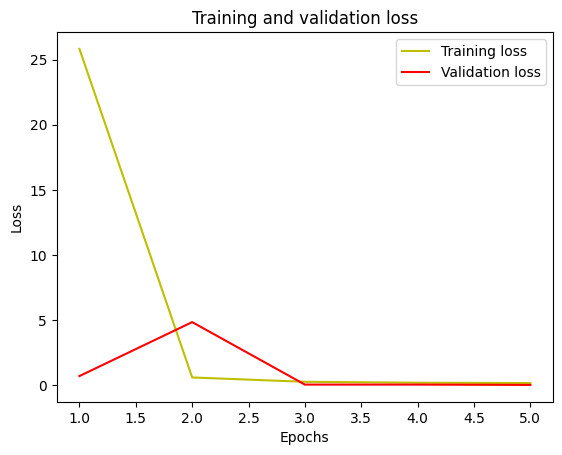

In [51]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
y_pred = model.predict(x_test_reshaped)

error_stats(y_test, y_pred, statistical_metric=None)

NameError: name 'model' is not defined

In [39]:
# import pandas as pd 
# x_rssi_test = pd.read_csv('files/x_rssi_test.csv', index_col=0)
# x_w_test = pd.read_csv('files/x_w_test.csv', index_col=0)

# time_ref1 = x_rssi_test[['timestamp', 'gw_ref']].reset_index(drop=True)
time_ref2 = x_w_test[['timestamp', 'gw_ref']].reset_index(drop=True)


# df1 = pd.DataFrame(y_rssi_pred, columns=['pred_lat', 'pred_lon'])
df2 = pd.DataFrame(y_w_pred, columns=['pred_lat', 'pred_lon'])




NameError: name 'y_w_pred' is not defined

In [12]:
# out1 = pd.concat([time_ref1, pd.DataFrame(y_rssi_test, columns=['lat', 'lon']), df1], axis=1)
# out1.to_csv('files/position_pred_RSSI.csv')

out2 = pd.concat([time_ref2, pd.DataFrame(y_w_test, columns=['lat', 'lon']), df2], axis=1)
out2.to_csv('files/position_pred_weather-comb.csv')


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
